# 0.0 Imports

In [111]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from warnings import filterwarnings
from category_encoders import TargetEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from boruta import BorutaPy
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
pd.set_option('display.max_columns', None)
filterwarnings('ignore')

# 1.0 Collect Data

In [40]:
# Import
pesquisas = pd.read_csv('pesquisas_eleitorais.csv')
resultados = pd.read_csv('resultados_eleicao.csv')

# 2.0 Data Cleaning

## 2.1 Filtering Rows 

In [41]:
# Em uma primeira versão deste trabalho utilizarei apenas pesquisas de presidente da república
pesquisas = pesquisas[pesquisas['cargo']=='presidente']

# Em uma primeira versão deste trabalho utilizarei apenas dados das eleições de 2006 em diante
pesquisas = pesquisas[pesquisas['ano']>=2006]

## 2.2 NaN Values

In [42]:
pesquisas.isna().sum()

id_pesquisa                   0
ano                           0
sigla_uf                  14241
nome_municipio            33041
cargo                         0
data                          0
data_referencia               0
instituto                     0
contratante                7470
orgao_registro             8339
numero_registro            8366
quantidade_entrevistas       29
margem_mais                   0
margem_menos                  0
tipo                        225
turno                         0
tipo_voto                     0
id_cenario                    0
descricao_cenario             0
id_candidato_poder360         0
nome_candidato                0
sigla_partido              9434
condicao                      0
percentual                    0
dtype: int64

### 2.2.1 Tipo do Cenário

In [43]:
pesquisas[pesquisas['tipo'].isna()]

,id_pesquisa,ano,sigla_uf,nome_municipio,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
29,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,5441,Ruim/Péssimo,NaN,1,35.0
30,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,5440,Ótimo/Bom,NaN,1,37.0
31,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,5437,Regular,NaN,1,26.0
32,9225,2019,NaN,NaN,presidente,2019-08-31,28-31.ago.2019,IBPAD,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,votos totais,23137,avaliação do governo,1210,não sabe / não respondeu,NaN,1,2.0
34759,9270,2019,NaN,NaN,presidente,2019-04-03,1-3.abr.2019,Vox Populi,PT,NaN,NaN,1985.0,2.2,2.2,NaN,1,votos totais,23240,avaliação do governo,5437,Regular,NaN,1,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109145,9307,2020,NaN,NaN,presidente,2020-06-24,22-24.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23293,avaliação do governo Bolsonaro,1210,não sabe / não respondeu,NaN,1,9.0
109146,9307,2020,NaN,NaN,presidente,2020-06-24,22-24.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23293,avaliação do governo Bolsonaro,5557,desaprova,NaN,0,49.0
109147,9305,2020,NaN,NaN,presidente,2020-06-10,8-10.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23294,avaliação do governo Bolsonaro,1210,não sabe / não respondeu,NaN,1,10.0
109148,9305,2020,NaN,NaN,presidente,2020-06-10,8-10.jun.2020,DataPoder360,NaN,NaN,NaN,2500.0,2.0,2.0,NaN,1,votos totais,23294,avaliação do governo Bolsonaro,5557,desaprova,NaN,0,50.0


Me parece que essas pesquisas não são eleitorais!

In [44]:
pesquisas[pesquisas['tipo'].isna()]['descricao_cenario'].unique()

array(['avaliação do governo', 'avaliação de governo',
       'aprovação do governo', 'avaliação do  governo',
       'avaliação do governo (trabalho de Bolsonaro)',
       'avaliação do trabalho de Bolsonaro',
       'avaliação do governo Bolsonaro'], dtype=object)

De fato era isso. Vou dropar!

In [45]:
pesquisas = pesquisas[~pesquisas['tipo'].isna()]

### 2.2.2 Município

In [46]:
print('Número de linhas:',pesquisas.shape[0])
print('Número de linhas com município vazio:',pesquisas[(pesquisas['nome_municipio'].isna())].shape[0])

Número de linhas: 32823
Número de linhas com município vazio: 32816


In [47]:
# Vou dropar, pois basicamente é tudo NaN
pesquisas = pesquisas.drop('nome_municipio',1)

### 2.2.3 UF

In [48]:
# UF vazia
pesquisas[(pesquisas['sigla_uf'].isna())]

,id_pesquisa,ano,sigla_uf,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,1508,Rui Costa Pimenta,PCO,0,0.0
1,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,938,Luciano Bivar,PSL,0,0.0
2,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,327,Cristovam Buarque,PDT,0,2.0
3,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,645,Heloísa Helena,Psol,0,9.0
4,8023,2006,NaN,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,806,Eymael,PSDC,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149377,3487,2014,NaN,presidente,2014-10-25,25/OUT/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8594,Diversos candidatos,176,Aécio Neves,PSDB,0,43.0
149378,3487,2014,NaN,presidente,2014-10-25,25/OUT/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8594,Diversos candidatos,214,branco / nulo / não sabe / não respondeu,NaN,1,10.0
149379,3487,2014,NaN,presidente,2014-10-25,25/OUT/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8594,Diversos candidatos,361,Dilma Rousseff,PT,0,47.0
149380,3488,2014,NaN,presidente,2014-10-25,25/Oct/2014,Datafolha,Folha de S/ Paulo/TV Globo,TSE,BR- 01210/2014,19318.0,2.0,2.0,estimulada,2,votos totais,8595,Diversos candidatos (votos válidos),176,Aécio Neves,PSDB,0,48.0


In [49]:
# Por agora vou dropar, mas posso rever depois (dada a grande quantidade de NaN)
pesquisas = pesquisas.drop('sigla_uf',1)

### 2.2.4 Contratante

In [50]:
pesquisas[pesquisas['contratante'].isna()]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,1508,Rui Costa Pimenta,PCO,0,0.0
1,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,938,Luciano Bivar,PSL,0,0.0
2,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,327,Cristovam Buarque,PDT,0,2.0
3,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,645,Heloísa Helena,Psol,0,9.0
4,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,NaN,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,806,Eymael,PSDC,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148787,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,855,João Doria,PSDB,0,1.5
148788,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,973,Lula,PT,0,51.5
148789,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,678,indeciso / não sabe / não respondeu,NaN,1,16.0
148790,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,NaN,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,575,Alckmin,PSDB,0,2.0


In [51]:
# Vou imputar um valor por enquanto
pesquisas['contratante'] = pesquisas['contratante'].fillna('Sem dados')

### 2.2.5 Órgão e Número de Registro

In [52]:
# Ambos vazios
pesquisas[(pesquisas['orgao_registro'].isna())&(pesquisas['numero_registro'].isna())]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
0,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,1508,Rui Costa Pimenta,PCO,0,0.0
1,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,938,Luciano Bivar,PSL,0,0.0
2,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,327,Cristovam Buarque,PDT,0,2.0
3,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,645,Heloísa Helena,Psol,0,9.0
4,8023,2006,presidente,2006-09-19,18-19.set.06,Datafolha,Sem dados,NaN,NaN,NaN,2.0,2.0,estimulada,1,votos totais,20265,cenário único - estimulado,806,Eymael,PSDC,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148787,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,855,João Doria,PSDB,0,1.5
148788,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,973,Lula,PT,0,51.5
148789,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,678,indeciso / não sabe / não respondeu,NaN,1,16.0
148790,7633,2018,presidente,2017-09-04,1-4.set.2017,Instituto Falpe,Sem dados,NaN,NaN,1534.0,3.0,3.0,estimulada,1,votos totais,18909,cenário estimulado,575,Alckmin,PSDB,0,2.0


In [53]:
# Com número, mas sem órgão
pesquisas[(pesquisas['orgao_registro'].isna())&(pesquisas['numero_registro'].notna())]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual


In [54]:
# Sem número, mas com órgão
pesquisas[(pesquisas['orgao_registro'].notna())&(pesquisas['numero_registro'].isna())]

,id_pesquisa,ano,cargo,data,data_referencia,instituto,contratante,orgao_registro,numero_registro,quantidade_entrevistas,margem_mais,margem_menos,tipo,turno,tipo_voto,id_cenario,descricao_cenario,id_candidato_poder360,nome_candidato,sigla_partido,condicao,percentual
89668,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,706,Bolsonaro,sem partido,0,34.0
89669,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,4982,branco / nulo / nenhum,NaN,1,7.5
89670,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,855,João Doria,PSDB,0,5.2
89671,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,973,Lula,PT,0,29.3
89672,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,841,João Amoêdo,Novo,0,4.1
89673,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,3438,Luiz Henrique Mandetta,DEM,0,1.5
89674,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,289,Ciro,PDT,0,5.9
89675,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,1210,não sabe / não respondeu,NaN,1,3.4
89676,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,1563,Simone Tebet,MDB,0,0.3
89677,9726,2022,presidente,2021-06-10,7-10.jun.2021,Paraná Pesquisas,Sem dados,Tribunal Superior Eleitoral,NaN,1818.0,2.5,2.5,estimulada,1,votos totais,24401,cenário 1 - estimulado - 1º turno,3152,José Luiz Datena,sem partido,0,9.0


In [55]:
# Vou dropar o número de registro, pois ele decorre do órgão (não tem número sem órgão)
pesquisas.drop('numero_registro',1,inplace=True)

# Os que tiverem órgão de registro vazios vou imputar um valor arbitrário 
pesquisas['orgao_registro'] = pesquisas['orgao_registro'].fillna('Sem dados')

### 2.2.6 Quantidade de Entrevistas

In [56]:
# Por ser poucos valores, vou a priori imputar com uma medida de tendência central

<AxesSubplot:xlabel='quantidade_entrevistas', ylabel='Count'>

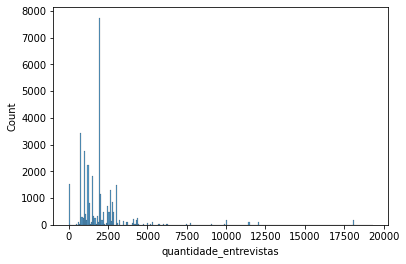

In [57]:
# Plot Histogram
sns.histplot(pesquisas['quantidade_entrevistas'])

In [58]:
# Medidas Descritivas
pesquisas['quantidade_entrevistas'].describe()

count    32798.000000
mean      2022.249283
std       1880.743198
min          0.000000
25%       1008.000000
50%       2000.000000
75%       2203.000000
max      19318.000000
Name: quantidade_entrevistas, dtype: float64

In [59]:
# São dado discrepantes. Vou colocar a median por ser mais resistente a outliers: representando melhor essa variavel
pesquisas['quantidade_entrevistas'] = pesquisas['quantidade_entrevistas'].fillna(pesquisas['quantidade_entrevistas'].median())

### 2.2.7 Partido

In [60]:
# Acredito que esse dado será importante para prever.

In [61]:
pesquisas[pesquisas['sigla_partido'].isna()]['nome_candidato'].unique()

array(['indeciso / não sabe / não respondeu',
       'branco / nulo / indeciso / nenhum', 'Outros',
       'No atual presidente', 'branco / nulo',
       'branco / nulo / não sabe / não respondeu',
       'não sabe / não respondeu',
       'Não rejeita nenhum / Poderia votar em qualquer um',
       'nenhum / não sabe / não respondeu', 'Não rejeita nenhum',
       'Joaquim Barbosa', 'Iram', 'Rejeita todos',
       'Não conhece os candidatos',
       'branco / nulo / indeciso / nenhum / não sabe / não respondeu',
       'Rejeita todos / Não votaria em nenhum', 'Candidato do PT',
       'Candidato do Lula', 'Poderia votar em qualquer um',
       'Não votaria em nenhum', 'Enéas', 'branco / nulo / nenhum',
       'indeciso', 'não sabe', 'branco / nulo / indeciso', 'nulo',
       'Mourão', 'não respondeu', 'ninguém/ nenhum/ branco / nulo',
       'nenhum', 'Não vota', 'branco / nulo / não votará',
       'Não escolheu ainda', 'não sabe / indeciso', 'branco',
       'Outras respostas', 'Rogér

No join esses brancos, indecisos, nulos.... vão sumir, restando apenas os candidatos que concorreram no pleito.
Esses vou colocar sem partido, pois estavam de fato sem partido quando foi feita a pesquisa

## 2.3 Inconsistent Data

### 2.3.1 Descrição Cenário

In [62]:
pesquisas['descricao_cenario'].unique()

array(['cenário único - estimulado', 'Diversos candidatos',
       'Lula vs Serra', 'Lula vs Aécio', 'Lula vs FHC',
       'Lula vs Alckmin', 'Lula vs Garotinho',
       'intenção Lula vs Alckmin', 'Dilma vs Aécio', 'Serra vs Genro',
       'Aécio vs Genro', 'Dilma vs Serra', 'Serra vs Patrus',
       'Diversos candidatos (votos válidos)',
       'Dilma vs Aécio (votos válidos)',
       'cenário 1 - estimulada - 1° turno',
       'cenário 1 - estimulado - 1º turno',
       'cenário 1 - espontâneo - 1º turno',
       'cenário 1 - espontânea - 1º turno',
       'cenário 2 - estimulada - 1º turno',
       'cenário 3 - estimulada - 1º turno',
       'cenário 1 - estimulada - 1º turno',
       'cenário 2 - estimulada - 2º turno',
       'cenário 4 - espontânea - 1º turno',
       'cenário 2 - estimulado - 1º turno',
       'cenário 3 - estimulado - 1º turno',
       'cenário 4 - estimulado - 1º turno',
       'cenário 5 - estimulado - 1º turno',
       'cenário 6 - estimulado - 1º turno',
 

In [63]:
# Os cenários que não existiram no segundo turno irão sumir quando fizermos nosso dataset final

In [64]:
# Remove avaliação do governo!
pesquisas = pesquisas[~pesquisas['descricao_cenario'].str.contains('avali')]

### 2.3.2 Tipo do cenário

In [65]:
pesquisas['tipo'].unique()

array(['estimulada', 'espontânea', 'rejeição'], dtype=object)

In [66]:
# Não quero de rejeição
pesquisas = pesquisas[~pesquisas['tipo'].str.contains('rejei')]

### 2.3.3 Conferir conferência entre tipo_voto e desc_cenário

In [67]:
# Verificar se os que tem entre parênteses "votos válidos" estão com o tipo do voto correto

In [68]:
pesquisas[pesquisas['descricao_cenario'].str.contains('votos')]['tipo_voto'].unique()

array(['votos totais', 'votos válidos'], dtype=object)

Vemos aqui que não! Temos que corrigir

In [69]:
index = pesquisas[pesquisas['descricao_cenario'].str.contains('votos')].index
pesquisas.loc[index,'tipo_voto'] = 'votos válidos'

### 2.3.4 Órgão Regulador

In [70]:
# Quero ver se os nomes são únicos ou se há variação nos nomes
pesquisas['orgao_registro'].unique()

array(['Sem dados', 'TSE', 'TRE', 'TRE-SP', 'TRE-AL', 'TRE-PE',
       '40ª Zona Eleitoral de Betim', 'TRE-MG', 'TRE-RJ', 'TRE-ES',
       'TRE-RS', 'TRE-BA', 'TRE-DF', 'Tribunal Superior Eleitoral',
       'TRE-GO', 'TRE-CE', 'TRE-MS', 'TRE-PR', 'TRE-RN', 'TRE-AM',
       'TRE-MT', 'TRE-TO', 'TRE-MA', 'TRE-PB', 'TRE-PA', 'TRE-SE',
       'TRE-PI', 'TRE-AP', 'TRE-RO', 'TRE-RR', 'TRE/SC', 'TRE - SC',
       'n.d', 'TRE-AC'], dtype=object)

In [71]:
index = pesquisas[pesquisas['orgao_registro'].str.contains('Tribunal Superior')].index
pesquisas.loc[index,'orgao_registro'] = 'TSE'
index = pesquisas[pesquisas['orgao_registro'].str.contains('n.d')].index
pesquisas.loc[index,'orgao_registro'] = 'Sem dados'

### 2.3.5 Contratante

In [72]:
# Quero ver se os nomes são únicos ou se há variação nos nomes
pesquisas['contratante'].unique()

array(['Sem dados', 'Rádio e Televisão Bandeirantes Ltda', 'TV Globo',
       'Rádio e Televisão Bandeirantes', 'A Gazeta', 'TV Bandeirantes',
       'Rádio e Televisão Bandeirantes e IG',
       'O & P Brasil Opinião Análise e Estratégia', 'Jornal Opção',
       'Fortiori', 'TV Atalaia', 'Jornal da Cidade', 'Sul21', 'TV Gazeta',
       'Record TV', 'Gazeta de São Paulo', 'TV Mirante',
       'TV Rádio Clube de Teresina', 'Grupo Globo', 'NC Comunicações',
       'Centro Norte Comunicação', 'Gazeta', 'O Povo/ Folha de S/ Paulo',
       'Rede Gazeta', 'A Tarde', 'Arko Advice', 'Genial Investimentos',
       'Grupo RBS', 'Folha de S/ Paulo', 'Folha de S.Paulo', 'O Popular',
       'Jornal do Tocantins', 'ACIEG', 'Grupo Jaime Câmara',
       'J. Camara & Irmãos', 'Folha de S. Paulo e Grupo Globo',
       'Folha da Manhã', 'TV Band Paraná', 'Band Natal', 'Veritá',
       'jornal Correio do Estado', 'Paraná Pesquisas', 'Jovem Pan',
       'Band Paraná', 'Nri Serviços', 'Bahia Notícias',
    

In [73]:
# Há bastante variação, talvez valha a pena parar um pouco aqui.

## 2.4 Drop Irrelevant Columns

In [74]:
# Cargo é cte, data_referencia não é a data da pesquisa e nome do candidato já tem id
pesquisas.drop(['cargo','data_referencia','nome_candidato'],1,inplace=True)

## 2.4 Data Dtypes

In [75]:
pesquisas.dtypes

id_pesquisa                 int64
ano                         int64
data                       object
instituto                  object
contratante                object
orgao_registro             object
quantidade_entrevistas    float64
margem_mais               float64
margem_menos              float64
tipo                       object
turno                       int64
tipo_voto                  object
id_cenario                  int64
descricao_cenario          object
id_candidato_poder360       int64
sigla_partido              object
condicao                    int64
percentual                float64
dtype: object

In [76]:
pesquisas['data'] = pd.to_datetime(pesquisas['data'])

In [77]:
resultados.dtypes

nome              object
partido           object
votos            float64
votos_validos    float64
total_votos      float64
turno              int64
ano                int64
id_poder_360       int64
dtype: object

# 3.0 Feature Engineering

In [78]:
# Local e Órgão de Registro 

pesquisas['local_registro'] = pesquisas['orgao_registro'].map({'Sem dados':'Sem dados', 'TSE':'Esfera Federal', 'TRE':'Esfera Estadual', 
        'TRE-SP':'SP', 'TRE-AL':'AL', 'TRE-PE':'PE',
       '40ª Zona Eleitoral de Betim':'MG', 'TRE-MG':'MG', 'TRE-RJ':'RJ', 'TRE-ES':'ES',
       'TRE-RS':'RS', 'TRE-BA':'BA', 'TRE-DF':'DF', 'TRE-GO':'GO', 'TRE-CE':'CE', 'TRE-MS':'MS',
       'TRE-PR':'PR', 'TRE-RN':'RN', 'TRE-AM':'AM', 'TRE-MT':'MT', 'TRE-TO':'TO', 'TRE-MA':'MA',
       'TRE-PB':'PB', 'TRE-PA':'PA', 'TRE-SE':'SE', 'TRE-PI':'PI', 'TRE-AP':'AP', 'TRE-RO':'RO',
       'TRE-RR':'RR', 'TRE/SC':'SC', 'TRE - SC':'SC', 'TRE-AC':'AC'})

pesquisas['orgao_registro'] = pesquisas['orgao_registro'].map({'Sem dados':'Sem dados', 'TSE':'TSE', 'TRE':'TRE', 
        'TRE-SP':'TRE', 'TRE-AL':'TRE', 'TRE-PE':'TRE',
       '40ª Zona Eleitoral de Betim':'Zona Eleitoral', 'TRE-MG':'TRE', 'TRE-RJ':'TRE', 'TRE-ES':'TRE',
       'TRE-RS':'TRE', 'TRE-BA':'TRE', 'TRE-DF':'TRE', 'TRE-GO':'TRE', 'TRE-CE':'TRE', 'TRE-MS':'TRE',
       'TRE-PR':'TRE', 'TRE-RN':'TRE', 'TRE-AM':'TRE', 'TRE-MT':'TRE', 'TRE-TO':'TRE', 'TRE-MA':'TRE',
       'TRE-PB':'TRE', 'TRE-PA':'TRE', 'TRE-SE':'TRE', 'TRE-PI':'TRE', 'TRE-AP':'TRE', 'TRE-RO':'TRE',
       'TRE-RR':'TRE', 'TRE/SC':'TRE', 'TRE - SC':'TRE', 'TRE-AC':'TRE'})

In [79]:
# Pct Votos Totais/Validos
resultados['pct_votos_validos'] = resultados['votos']/resultados['votos_validos']
resultados['pct_votos_totais'] = resultados['votos']/resultados['total_votos']

In [80]:
# Dia da Eleição (Ano e turno)

pesquisas['data_eleicao'] = np.nan

# 2006
index = pesquisas[(pesquisas['ano']==2006)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('01/10/2006')
index = pesquisas[(pesquisas['ano']==2006)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('29/10/2006')

# 2010
index = pesquisas[(pesquisas['ano']==2010)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('03/10/2010')
index = pesquisas[(pesquisas['ano']==2010)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('31/10/2010')

# 2014
index = pesquisas[(pesquisas['ano']==2014)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('05/10/2014')
index = pesquisas[(pesquisas['ano']==2014)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('26/10/2014')

# 2018
index = pesquisas[(pesquisas['ano']==2018)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('07/10/2018')
index = pesquisas[(pesquisas['ano']==2018)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('28/10/2018')

# 2022
index = pesquisas[(pesquisas['ano']==2022)&(pesquisas['turno']==1)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('02/10/2022')
index = pesquisas[(pesquisas['ano']==2022)&(pesquisas['turno']==2)].index
pesquisas.loc[index,'data_eleicao'] = pd.to_datetime('30/10/2022')

In [81]:
# Dias para a eleição
pesquisas['timedelta_eleicao'] = (pesquisas['data'] - pesquisas['data_eleicao']).dt.days

In [83]:
# Meses desde o último censo
data_ultimo_censo = pesquisas['data'].dt.year.apply(lambda x: pd.to_datetime('01/12/2000') if x <= 2010 else pd.to_datetime('01/12/2010'))
pesquisas['timedelta_censo'] = (pesquisas['data'] - data_ultimo_censo).dt.days/30

# 4.0 Final Dataset

## 4.1 Left Join

In [84]:
resultados['join_aux'] = resultados['id_poder_360'].astype('str')+resultados['ano'].astype('str')+resultados['turno'].astype('str')
pesquisas['join_aux'] = pesquisas['id_candidato_poder360'].astype('str')+pesquisas['ano'].astype('str')+pesquisas['turno'].astype('str')
dados = pd.merge(pesquisas,resultados[['pct_votos_validos','pct_votos_totais','join_aux']],on='join_aux',how='left')
dados.drop('join_aux',1,inplace=True)

## 4.2 Drop NaN Results Candidates

In [85]:
dados = dados[~dados['pct_votos_validos'].isna()]

## 4.3 Continue Feature Engineering

In [86]:
# Qtd de candidatos no cenario que não participaram efetivamente do pleito
aux = pesquisas.groupby('id_cenario').count()['id_candidato_poder360'].reset_index().rename(columns={'id_candidato_poder360':'qtd_candidatos'})
aux2 = dados.groupby('id_cenario').count()['id_candidato_poder360'].reset_index().rename(columns={'id_candidato_poder360':'qtd_candidatos_participaram'})
df_aux = pd.merge(aux,aux2,on='id_cenario',how='inner')
dados = pd.merge(dados,df_aux,on='id_cenario',how='left')

In [87]:
# % Relativo dos que efetiv. concorreram
dados['pct_participacao_candidatos'] = dados['qtd_candidatos_participaram']/dados['qtd_candidatos']

In [88]:
# % Total da Pesquisa, % dos que participaram, % dos que não participaram
aux = pesquisas.groupby('id_cenario').sum()['percentual'].reset_index().rename(columns={'percentual':'cum_cenario_pct'})
aux2 = dados.groupby('id_cenario').sum()['percentual'].reset_index().rename(columns={'percentual':'cum_cenario_pct_participaram'})
df_aux = pd.merge(aux,aux2,on='id_cenario',how='inner')
df_aux['cum_cenario_pct_nao_participaram'] = df_aux['cum_cenario_pct']-df_aux['cum_cenario_pct_participaram']
dados = pd.merge(dados,df_aux,on='id_cenario',how='left')

## 4.4 Remove 2 Turno Não Efetivado

In [89]:
# Remove cenários 2 turno que só tem um candidato (Ex: ciro e lula em 2022, só lula foi pro 2 turno, então dropar esse cenário!)
cenarios2turno = dados[dados['turno']==2]['id_cenario'].unique()
lst = []
for cenario in cenarios2turno:
    if dados[dados['id_cenario']==cenario].shape[0] == 1:
        lst.append(cenario)
dados = dados[~dados['id_cenario'].isin(lst)]

## 4.5 Erro da Pesquisa

In [90]:
# Real - Predito

dados.reset_index(drop=True,inplace=True)

dados['real'] = np.nan
for c in range(dados.shape[0]):
    if dados.loc[c,'tipo_voto']=='votos totais':
        dados.loc[c,'real']=dados.loc[c,'pct_votos_totais']
    elif dados.loc[c,'tipo_voto']=='votos válidos':
        dados.loc[c,'real']=dados.loc[c,'pct_votos_validos']
dados['real'] = dados['real']*100
dados['erro'] = dados['real'] - dados['percentual']

dados.drop(['pct_votos_validos','pct_votos_totais','real'],1,inplace=True)

## 4.6 Fill NaN Partido

In [93]:
dados['sigla_partido'].fillna('Sem partido',inplace=True)

# 5.0 Data Preparation

## 5.1 Train Test Split (Time Series Constraint)

In [95]:
dados = dados.sort_values('data')

train = dados[dados['ano']!=2022]
test = dados[dados['ano']==2022]

x_train,y_train = train.drop('erro',1),train['erro']
x_test,y_test = test.drop('erro',1),test['erro']

## 5.2 Drop Datetime Variables

In [96]:
x_train.drop(['data_eleicao','data'],1,inplace=True)
x_test.drop(['data_eleicao','data'],1,inplace=True)

## 5.3 Avoid data leakage and Overfitting

In [97]:
x_train.drop(['id_pesquisa','id_cenario'],1,inplace=True)
x_test.drop(['id_pesquisa','id_cenario'],1,inplace=True)

## 5.3 Encoding

In [98]:
# fazer um encoding decente

In [103]:
te = TargetEncoder()
te.fit(x_train['instituto'],y_train)
x_train['instituto'] = te.transform(x_train['instituto'])
x_test['instituto'] = te.transform(x_test['instituto'])

te.fit(x_train['contratante'],y_train)
x_train['contratante'] = te.transform(x_train['contratante'])
x_test['contratante'] = te.transform(x_test['contratante'])

te.fit(x_train['orgao_registro'],y_train)
x_train['orgao_registro'] = te.transform(x_train['orgao_registro'])
x_test['orgao_registro'] = te.transform(x_test['orgao_registro'])

te.fit(x_train['tipo'],y_train)
x_train['tipo'] = te.transform(x_train['tipo'])
x_test['tipo'] = te.transform(x_test['tipo'])

te.fit(x_train['tipo_voto'],y_train)
x_train['tipo_voto'] = te.transform(x_train['tipo_voto'])
x_test['tipo_voto'] = te.transform(x_test['tipo_voto'])

te.fit(x_train['descricao_cenario'],y_train)
x_train['descricao_cenario'] = te.transform(x_train['descricao_cenario'])
x_test['descricao_cenario'] = te.transform(x_test['descricao_cenario'])

te.fit(x_train['sigla_partido'],y_train)
x_train['sigla_partido'] = te.transform(x_train['sigla_partido'])
x_test['sigla_partido'] = te.transform(x_test['sigla_partido'])

te.fit(x_train['local_registro'],y_train)
x_train['local_registro'] = te.transform(x_train['local_registro'])
x_test['local_registro'] = te.transform(x_test['local_registro'])

## 5.3 Reescaling

In [104]:
# fazer um reescaling decente

In [105]:
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

## 5.4 Feature Selection

In [106]:
boruta = BorutaPy(RandomForestRegressor(n_jobs=-1),n_estimators='auto',verbose=2,random_state=101)
boruta.fit(np.array(x_train),np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	14
Tentative: 	4
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	4
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	14
Tentative: 	4
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	14
Tentative: 	4
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	4
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	3
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	3
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	14
Tentative: 	3
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	14
Tentative: 	2
Rejected: 	8
I

BorutaPy(estimator=RandomForestRegressor(n_estimators=56, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x2898FFE40),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x2898FFE40,
         verbose=2)

In [107]:
# Colunas escolhidas
dados.drop(['data_eleicao','data','erro','id_pesquisa','id_cenario'],1).columns[boruta.support_]

Index(['ano', 'tipo', 'turno', 'descricao_cenario', 'id_candidato_poder360',
       'sigla_partido', 'percentual', 'local_registro', 'timedelta_eleicao',
       'timedelta_censo', 'qtd_candidatos', 'qtd_candidatos_participaram',
       'pct_participacao_candidatos', 'cum_cenario_pct_participaram',
       'cum_cenario_pct_nao_participaram'],
      dtype='object')

In [108]:
x_train = pd.DataFrame(x_train,columns=dados.drop(['data_eleicao','data','erro','id_pesquisa','id_cenario'],1).columns)
x_test = pd.DataFrame(x_test,columns=dados.drop(['data_eleicao','data','erro','id_pesquisa','id_cenario'],1).columns)
x_train = x_train.loc[:,boruta.support_]
x_test = x_test.loc[:,boruta.support_]

# 6.0 Model Selection and Evaluation

## 6.1 Hould Out

In [109]:
def houldout(model):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    y_true = y_test

    mae = mean_absolute_error(y_true,y_pred)
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print('MAE: {:.2f}\nRMSE: {:.2f}'.format(mae,rmse))

### 6.1.1 Linear Regression

In [112]:
houldout(LinearRegression())

MAE: 14.61
RMSE: 18.22


### 6.1.2 RandomForest

In [113]:
houldout(RandomForestRegressor())

MAE: 8.90
RMSE: 13.37


### 6.1.3 XGBoost

In [114]:
houldout(XGBRegressor())

MAE: 9.74
RMSE: 13.40


In [115]:
houldout(XGBRegressor())

MAE: 9.74
RMSE: 13.40


### 6.1.4 LGBM

In [116]:
houldout(LGBMRegressor())

MAE: 8.38
RMSE: 11.16


In [117]:
houldout(LGBMRegressor())

MAE: 8.38
RMSE: 11.16


## Cross Validation

In [ ]:
# fazer com a restrição da timeseries

# 7.0 Hyperparameter Finetuning

# 8.0 Error and Business Interpretation 

In [ ]:
# coletar dados segundo turno 2022 e ver as previsões!